In [1]:
!pip uninstall -y torch torchvision torchaudio


!pip install torch==2.3.0 torchvision==0.18.0 torchaudio==2.3.0 --index-url https://download.pytorch.org/whl/cu118
!pip install transformers==4.41.0

!wget https://github.com/state-spaces/mamba/releases/download/v2.2.2/mamba_ssm-2.2.2+cu122torch2.3cxx11abiFALSE-cp311-cp311-linux_x86_64.whl

!pip install mamba_ssm-2.2.2+cu122torch2.3cxx11abiFALSE-cp311-cp311-linux_x86_64.whl

!pip install causal-conv1d>=1.4.0

import torch
print("PyTorch:", torch.__version__)  # e.g., 2.1.0+cu121
print("CUDA:", torch.version.cuda)    # e.g., 12.1
!python --version   

import torch
import random
import torch.nn as nn
import torch.nn.functional as F
from mamba_ssm import Mamba
from torch.optim import Adam
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader
from tqdm import tqdm
import numpy as np
from datasets import load_dataset
from transformers import AutoTokenizer
from transformers import GPT2Tokenizer
from mamba_ssm.models.mixer_seq_simple import MixerModel
from mamba_ssm.models.mixer_seq_simple import MambaLMHeadModel
from transformers import AutoModelForCausalLM
from mamba_ssm.models.config_mamba import MambaConfig

Found existing installation: torch 2.6.0+cu124
Uninstalling torch-2.6.0+cu124:
  Successfully uninstalled torch-2.6.0+cu124
Found existing installation: torchvision 0.21.0+cu124
Uninstalling torchvision-0.21.0+cu124:
  Successfully uninstalled torchvision-0.21.0+cu124
Found existing installation: torchaudio 2.6.0+cu124
Uninstalling torchaudio-2.6.0+cu124:
  Successfully uninstalled torchaudio-2.6.0+cu124
Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 839.7/839.7 MB 2.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 21.6 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 79.5 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 80.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 38.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 105.3 MB/s eta 0:00:0000:0100:01
    

✅ Original Data:
📐 Shape: (619040, 7)
🧾 Columns: ['date', 'open', 'high', 'low', 'close', 'volume', 'Name']

🔍 Sample Data:
         date   open   high    low  close    volume Name
0  2013-02-08  15.07  15.12  14.63  14.75   8407500  AAL
1  2013-02-11  14.89  15.01  14.26  14.46   8882000  AAL
2  2013-02-12  14.45  14.51  14.10  14.27   8126000  AAL
3  2013-02-13  14.30  14.94  14.25  14.66  10259500  AAL
4  2013-02-14  14.94  14.96  13.16  13.99  31879900  AAL
AAL Stock Data Shape before: (1259, 6)
Dataset sizes:
Training: 877 sequences
Validation: 188 sequences
Testing: 189 sequences
torch.Size([16, 5, 5])


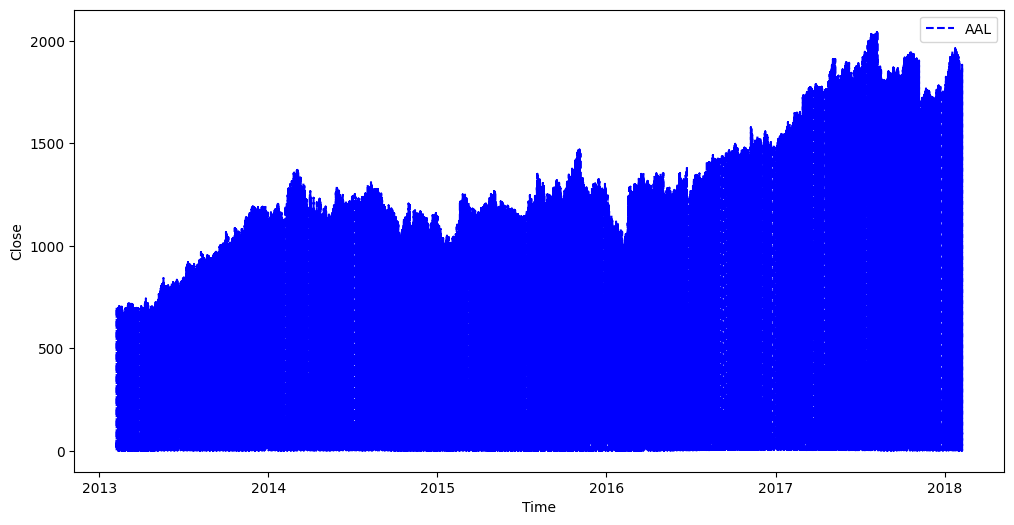

In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pylab as plt
df = pd.read_csv('/kaggle/input/aaaaaaa/all_stocks_5yr.csv')
    
print("✅ Original Data:")
print(f"📐 Shape: {df.shape}")
print(f"🧾 Columns: {df.columns.tolist()}")
print("\n🔍 Sample Data:")
print(df.head())

# Drop rows with missing values (if any)
df = df.dropna()

# Convert and sort by date
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)

aapl_df = df[df['Name'] == 'AAL'].copy()
aapl_df.set_index('date', inplace=True)  # Set date as index for time-based operations
print(f"AAL Stock Data Shape before: {aapl_df.shape}")
#print(aapl_df.head())
df.describe()


# Select features and target
feature_cols = ['open', 'high', 'low', 'close', 'volume']
target_col = 'close'

features = aapl_df[feature_cols].values.astype(np.float32)
target = aapl_df[target_col].values.astype(np.float32)

# Normalize features and target separately
feature_scaler = StandardScaler()
target_scaler = StandardScaler()

scaled_features = feature_scaler.fit_transform(features)
scaled_target = target_scaler.fit_transform(target.reshape(-1, 1))

# Create sequences with multiple features
def create_sequences(features, target, seq_length, pred_length):
    X, y = [], []
    for i in range(len(features) - seq_length - pred_length + 1):
        X.append(features[i:i+seq_length])  # Shape: (seq_length, num_features)
        y.append(target[i+seq_length:i+seq_length+pred_length])  # Shape: (pred_length,)
    return np.array(X), np.array(y)

SEQ_LENGTH = 5
PRED_LENGTH = 1

X, y = create_sequences(scaled_features, scaled_target, SEQ_LENGTH, PRED_LENGTH)
total_size = len(X)
train_size = int(0.7 * total_size)  # 60% training
val_size = int(0.15 * total_size)    # 20% validation
# test_size = total_size - train_size - val_size (remaining 20%)

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

print(f"Dataset sizes:")
print(f"Training: {X_train.shape[0]} sequences")
print(f"Validation: {X_val.shape[0]} sequences")
print(f"Testing: {X_test.shape[0]} sequences")

X_train_tensor = torch.tensor(X_train).float()
y_train_tensor = torch.tensor(y_train).float()
X_val_tensor = torch.tensor(X_val).float()
y_val_tensor = torch.tensor(y_val).float()
X_test_tensor = torch.tensor(X_test).float()
y_test_tensor = torch.tensor(y_test).float()

# Create DataLoaders
batch_size = 16
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

for batch in train_loader:
    print(batch[0].shape)  # for a single tensor
    break
plt.figure(figsize=(12, 6))
plt.plot(df['date'],df['close'],'--b',label="AAL")
plt.legend()
plt.xlabel('Time')
plt.ylabel('Close')
plt.show()

In [15]:
class SeriesDecomposition(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.kernel_size = kernel_size
        self.padding = kernel_size // 2
        self.avg_pool = nn.AvgPool1d(kernel_size, stride=1, padding=0)
        
    def forward(self, x):
        # Pad manually with replication
        x_perm = x.permute(0, 2, 1)
        x_padded = torch.nn.functional.pad(
            x_perm, 
            (self.padding, self.padding), 
            mode='replicate'
        )
        
        # Apply pooling
        trend = self.avg_pool(x_padded)
        trend = trend.permute(0, 2, 1)
        
        seasonal = x - trend
        return seasonal, trend

In [16]:
import torch
import torch.nn as nn

class BimambaEncoderLayer(nn.Module):
    def __init__(self, d_model, d_conv, d_state, expand, 
                 b_d_conv, b_d_state, b_expand, dropout, d_ff, kernel_size,
                 activation="relu", residual=True):
        super().__init__()
        self.decomp = SeriesDecomposition(kernel_size)
        # Mamba blocks (assumed defined elsewhere)
        self.mamba_forward = Mamba(
            d_model=d_model, d_state=d_state, d_conv=d_conv, expand=expand
        )
        self.mamba_backward = Mamba(
            d_model=d_model, d_state=b_d_state, d_conv=b_d_conv, expand=b_expand
        )
        # Normalization (pre-norm)
        self.norm = nn.LayerNorm(d_model)
        # Add/Norm layers
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.residual = residual
        # FFN
        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model)
        )

    def forward(self, seasonal_in, trend_in):

        seasonal_norm = self.norm(seasonal_in)
        
        # Forward Mamba block
        out_fwd = self.mamba_forward(seasonal_norm)
        
        # Backward Mamba block
        rev_input = seasonal_norm.flip(dims=[1])
        
        out_bwd = self.mamba_backward(rev_input)  # no mask passed
        out_bwd = out_bwd.flip(dims=[1])
        
        # Combine forward and backward outputs
        out = out_fwd + out_bwd
        seasonal_out = seasonal_in + self.dropout(out)
        seasonal_decomp, trend_update = self.decomp(seasonal_out)

        trend_out = trend_in + trend_update
        
        seasonal_norm2 = self.norm2(seasonal_decomp)
        ffn_out = self.ffn(seasonal_norm2)
        seasonal_final = seasonal_decomp + self.dropout(ffn_out)
        
        return seasonal_final, trend_out

class StockMambaEncoder(nn.Module):
    def __init__(self, input_features=5, d_model=64, n_layer=2, 
                 d_conv=2, d_state=16, expand=2, 
                 b_d_conv=2, b_d_state=16, b_expand=2, kernel_size=3,
                 dropout=0.1, d_ff=512):
        super().__init__()
        # Input projection
        self.input_proj = nn.Linear(input_features, d_model)
        # Initial decomposition
        self.init_decomp = SeriesDecomposition(kernel_size)
        # Trend projection
        self.trend_proj = nn.Linear(d_model, 1)
        # Encoder layers
        self.layers = nn.ModuleList([
            BimambaEncoderLayer(
                d_model=d_model, d_conv=d_conv, d_state=d_state, expand=expand,
                b_d_conv=b_d_conv, b_d_state=b_d_state, b_expand=b_expand, kernel_size=kernel_size,
                dropout=dropout, d_ff=d_ff
            ) for _ in range(n_layer)
        ])
        self._init_weights()

    def _init_weights(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, x, mask=None):
        #print(x.shape)
        x = self.input_proj(x)
        seasonal, trend = self.init_decomp(x)
        for layer in self.layers:
            seasonal, trend = layer(seasonal, trend)
        
        return seasonal, trend


In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SeriesDecomposition(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.avg_pool = nn.AvgPool1d(
            kernel_size=kernel_size, 
            stride=1, 
            padding=kernel_size//2
        )
    
    def forward(self, x):
        # x shape: (batch_size, seq_len, d_model)
        x = x.transpose(1, 2)  # -> (batch_size, d_model, seq_len)
        trend = self.avg_pool(x)
        seasonal = x - trend
        return seasonal.transpose(1, 2), trend.transpose(1, 2)

# Placeholder for Mamba block - replace with actual Mamba implementation
class Mamba(nn.Module):
    def __init__(self, d_model, d_state, d_conv, expand):
        super().__init__()
        # Simplified placeholder - replace with actual Mamba implementation
        self.d_model = d_model
        self.proj = nn.Sequential(
            nn.Linear(d_model, d_model * expand),
            nn.ReLU(),
            nn.Linear(d_model * expand, d_model)
        )
    
    def forward(self, x):
        return self.proj(x)

class StockMambaDecoderLayer(nn.Module):
    def __init__(
        self,
        d_model,
        d_conv,
        d_state,
        expand,
        kernel_size,
        dropout,
        d_ff,
        n_heads=4,
        activation="relu"
    ):
        super().__init__()
        self.decomposition = SeriesDecomposition(kernel_size)
        
        # Causal Mamba layer (decoder self-processing)
        self.causal_mamba = Mamba(
            d_model=d_model,
            d_state=d_state,
            d_conv=d_conv,
            expand=expand,
        )
        
        # Cross-attention layer (replaces cross-mamba)
        self.cross_attn = nn.MultiheadAttention(
            embed_dim=d_model,
            num_heads=n_heads,
            dropout=dropout,
            batch_first=True
        )
        
        # Feed-forward network
        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model),
            nn.Dropout(dropout)
        )
        
        # Normalization layers
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, target_seasonal, encoder_seasonal, encoder_trend):
        # 1. Causal Mamba processing
        target_norm = self.norm1(target_seasonal)
        causal_out = self.causal_mamba(target_norm)
        target_temp = target_seasonal + self.dropout(causal_out)
        
        # 2. Cross-attention (replaces cross-mamba)
        cross_attn_out, _ = self.cross_attn(
            query=self.norm2(target_temp),  # Decoder states as queries
            key=encoder_seasonal,          # Encoder outputs as keys
            value=encoder_seasonal,        # Encoder outputs as values
            need_weights=False
        )
        target_cross = target_temp + self.dropout(cross_attn_out)
        
        # 3. Time series decomposition
        seasonal_decomp, trend_update = self.decomposition(target_cross)
        
        # 4. Feed-forward network
        ffn_out = self.ffn(self.norm3(seasonal_decomp))
        seasonal_final = seasonal_decomp + self.dropout(ffn_out)
        
        return seasonal_final, trend_update

class StockMambaDecoder(nn.Module):
    def __init__(self,
                 d_model=64,
                 d_conv=2,
                 d_state=16,
                 expand=2,
                 n_heads=4,
                 n_layer=2,
                 dropout=0.1,
                 d_ff=256,
                 input_dim=1,
                 kernel_size=3,
                 output_dim=1,
                 pred_length=1):
        super().__init__()
        self.pred_length = pred_length
        
        self.input_proj = nn.Linear(input_dim, d_model)

        self.trend_init = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU()
        )
        
        # Decoder layers with cross-attention
        self.layers = nn.ModuleList([
            StockMambaDecoderLayer(
                d_model=d_model,
                d_conv=d_conv,
                d_state=d_state,
                expand=expand,
                kernel_size=kernel_size,
                dropout=dropout,
                d_ff=d_ff,
                n_heads=n_heads
            ) for _ in range(n_layer)
        ])

        # Prediction heads
        self.seasonal_head = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, output_dim)
        )
        
        self.trend_head = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, output_dim)
        )
        
        self._init_weights()

    def _init_weights(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p, gain=nn.init.calculate_gain('relu'))

    def forward(self, target, encoder_seasonal, encoder_trend):
        seasonal = self.input_proj(target)
        
        last_trend = encoder_trend[:, -1:, :]  # Last timestep
        trend = self.trend_init(last_trend)
        trend = trend.repeat(1, self.pred_length, 1)

        for layer in self.layers:
            seasonal, trend_update = layer(
                seasonal, 
                encoder_seasonal, 
                encoder_trend
            )
            trend = trend + trend_update

        seasonal_pred = self.seasonal_head(seasonal)
        trend_pred = self.trend_head(trend)

        predictions = seasonal_pred + trend_pred
        return predictions.squeeze(-1)

In [18]:
class Model(nn.Module):
    def __init__(self, input_features=5, d_model=64, pred_length=1):
        super().__init__()
        self.encoder = StockMambaEncoder(input_features, d_model)
        self.decoder = StockMambaDecoder(
            d_model=d_model,
            pred_length=pred_length,
            input_dim=1  # Close price only
        )
        self.pred_length = pred_length

    def forward(self, src):
        # 1. Encode source
        enc_seasonal, enc_trend = self.encoder(src)
        
        # 2. Prepare decoder input (last close price)
        last_close = src[:, -1:, 3:4]  # [batch, 1, 1]
        decoder_input = last_close.repeat(1, self.pred_length, 1)
        
        # 3. Decode
        predictions = self.decoder(
            decoder_input, 
            enc_seasonal, 
            enc_trend
        )
        return predictions

model = Model().to('cuda')

Epoch 1/30: 100%|██████████| 12/12 [00:00<00:00, 147.73it/s]


Epoch 1: Train Loss=0.0454, Val Loss=0.0590, Val RMSE=0.3427
-> Saved Best Model


Epoch 2/30: 100%|██████████| 12/12 [00:00<00:00, 178.44it/s]


Epoch 2: Train Loss=0.0241, Val Loss=0.0100, Val RMSE=0.1414
-> Saved Best Model


Epoch 3/30: 100%|██████████| 12/12 [00:00<00:00, 180.62it/s]


Epoch 3: Train Loss=0.0182, Val Loss=0.0159, Val RMSE=0.1777


Epoch 4/30: 100%|██████████| 12/12 [00:00<00:00, 186.08it/s]


Epoch 4: Train Loss=0.0170, Val Loss=0.0227, Val RMSE=0.2122


Epoch 5/30: 100%|██████████| 12/12 [00:00<00:00, 182.51it/s]


Epoch 5: Train Loss=0.0156, Val Loss=0.0118, Val RMSE=0.1529


Epoch 6/30: 100%|██████████| 12/12 [00:00<00:00, 180.96it/s]


Epoch 6: Train Loss=0.0177, Val Loss=0.0189, Val RMSE=0.1939


Epoch 7/30: 100%|██████████| 12/12 [00:00<00:00, 185.88it/s]


Epoch 7: Train Loss=0.0111, Val Loss=0.0069, Val RMSE=0.1164
-> Saved Best Model


Epoch 8/30: 100%|██████████| 12/12 [00:00<00:00, 178.53it/s]


Epoch 8: Train Loss=0.0086, Val Loss=0.0105, Val RMSE=0.1450


Epoch 9/30: 100%|██████████| 12/12 [00:00<00:00, 172.31it/s]


Epoch 9: Train Loss=0.0140, Val Loss=0.0091, Val RMSE=0.1343


Epoch 10/30: 100%|██████████| 12/12 [00:00<00:00, 183.22it/s]


Epoch 10: Train Loss=0.0085, Val Loss=0.0055, Val RMSE=0.1046
-> Saved Best Model


Epoch 11/30: 100%|██████████| 12/12 [00:00<00:00, 180.82it/s]


Epoch 11: Train Loss=0.0086, Val Loss=0.0049, Val RMSE=0.0974
-> Saved Best Model


Epoch 12/30: 100%|██████████| 12/12 [00:00<00:00, 181.79it/s]


Epoch 12: Train Loss=0.0095, Val Loss=0.0258, Val RMSE=0.2262


Epoch 13/30: 100%|██████████| 12/12 [00:00<00:00, 178.41it/s]


Epoch 13: Train Loss=0.0178, Val Loss=0.0050, Val RMSE=0.0994


Epoch 14/30: 100%|██████████| 12/12 [00:00<00:00, 180.81it/s]


Epoch 14: Train Loss=0.0083, Val Loss=0.0059, Val RMSE=0.1079


Epoch 15/30: 100%|██████████| 12/12 [00:00<00:00, 181.98it/s]


Epoch 15: Train Loss=0.0109, Val Loss=0.0220, Val RMSE=0.2090


Epoch 16/30: 100%|██████████| 12/12 [00:00<00:00, 177.93it/s]


Epoch 16: Train Loss=0.0069, Val Loss=0.0045, Val RMSE=0.0950
-> Saved Best Model


Epoch 17/30: 100%|██████████| 12/12 [00:00<00:00, 174.23it/s]


Epoch 17: Train Loss=0.0064, Val Loss=0.0044, Val RMSE=0.0923
-> Saved Best Model


Epoch 18/30: 100%|██████████| 12/12 [00:00<00:00, 169.94it/s]


Epoch 18: Train Loss=0.0064, Val Loss=0.0038, Val RMSE=0.0855
-> Saved Best Model


Epoch 19/30: 100%|██████████| 12/12 [00:00<00:00, 181.93it/s]


Epoch 19: Train Loss=0.0057, Val Loss=0.0054, Val RMSE=0.1027


Epoch 20/30: 100%|██████████| 12/12 [00:00<00:00, 179.34it/s]


Epoch 20: Train Loss=0.0057, Val Loss=0.0048, Val RMSE=0.0962


Epoch 21/30: 100%|██████████| 12/12 [00:00<00:00, 179.81it/s]


Epoch 21: Train Loss=0.0064, Val Loss=0.0041, Val RMSE=0.0893


Epoch 22/30: 100%|██████████| 12/12 [00:00<00:00, 177.69it/s]


Epoch 22: Train Loss=0.0050, Val Loss=0.0046, Val RMSE=0.0949


Epoch 23/30: 100%|██████████| 12/12 [00:00<00:00, 181.16it/s]


Epoch 23: Train Loss=0.0052, Val Loss=0.0044, Val RMSE=0.0930


Epoch 24/30: 100%|██████████| 12/12 [00:00<00:00, 176.61it/s]


Epoch 24: Train Loss=0.0049, Val Loss=0.0063, Val RMSE=0.1114


Epoch 25/30: 100%|██████████| 12/12 [00:00<00:00, 166.63it/s]


Epoch 25: Train Loss=0.0054, Val Loss=0.0039, Val RMSE=0.0873


Epoch 26/30: 100%|██████████| 12/12 [00:00<00:00, 179.18it/s]


Epoch 26: Train Loss=0.0045, Val Loss=0.0053, Val RMSE=0.1023


Epoch 27/30: 100%|██████████| 12/12 [00:00<00:00, 177.90it/s]


Epoch 27: Train Loss=0.0046, Val Loss=0.0046, Val RMSE=0.0952


Epoch 28/30: 100%|██████████| 12/12 [00:00<00:00, 175.17it/s]


Epoch 28: Train Loss=0.0043, Val Loss=0.0037, Val RMSE=0.0849
-> Saved Best Model


Epoch 29/30: 100%|██████████| 12/12 [00:00<00:00, 176.11it/s]


Epoch 29: Train Loss=0.0045, Val Loss=0.0051, Val RMSE=0.1001


Epoch 30/30: 100%|██████████| 12/12 [00:00<00:00, 175.28it/s]


Epoch 30: Train Loss=0.0044, Val Loss=0.0044, Val RMSE=0.0926


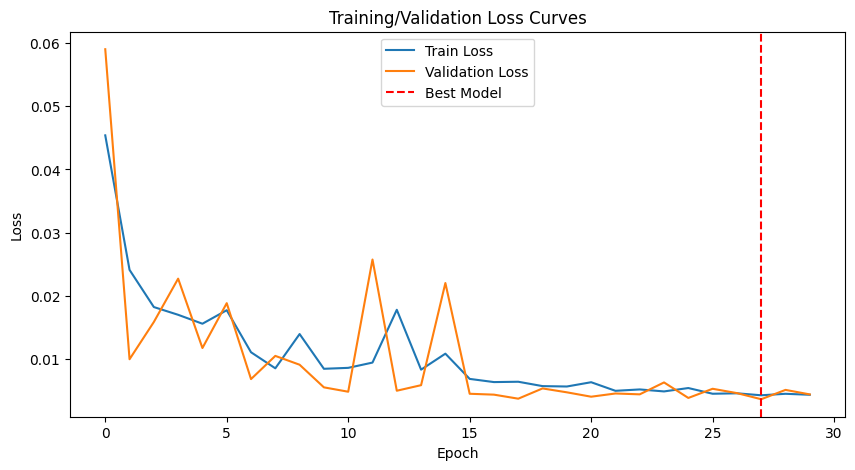

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import numpy as np
from sklearn.metrics import mean_squared_error
import random
import matplotlib.pyplot as plt

# Fix seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
set_seed()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Enhanced Loss Function
class StockLoss(nn.Module):
    def __init__(self, delta=0.5, direction_weight=0.6, margin=0.02):
        super().__init__()
        self.huber = nn.HuberLoss(delta=delta)
        self.direction_weight = direction_weight
        self.margin = margin
        
    def forward(self, preds, targets):
        # Base regression loss
        huber_loss = self.huber(preds, targets)
        
        # Directional loss only for multi-step predictions
        if preds.size(1) > 1:
            pred_dirs = preds[:, 1:] - preds[:, :-1]
            true_dirs = targets[:, 1:] - targets[:, :-1]
            
            # Only consider significant movements
            significant_moves = (true_dirs.abs() > self.margin).float()
            dir_accuracy = torch.sign(pred_dirs * true_dirs)
            
            # Loss for wrong directions on significant moves
            dir_loss = torch.mean(torch.relu(-dir_accuracy * significant_moves))
        else:
            dir_loss = torch.tensor(0.0, device=preds.device)
            
        return huber_loss + self.direction_weight * dir_loss




# Stronger regularization in optimizer
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-3)  # Increased weight decay
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)
criterion = StockLoss(delta=0.5, direction_weight=0.6, margin=0.02).to(device)

best_val_loss = float('inf')
no_improve = 0
patience = 10
train_losses = []
val_losses = []
epochs = 30

for epoch in range(1, epochs + 1):
    model.train()
    epoch_train_losses = []
    
    # Data augmentation with Gaussian noise
    for batch_X, batch_y in tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}"):
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        if model.training:  # Only add noise during training
            # Add noise only to features, not to sequence length
            noise = torch.randn_like(batch_X) * 0.01
            batch_X = batch_X + noise
        
        optimizer.zero_grad()
        
        
        preds = model(batch_X)
        loss = criterion(preds, batch_y.squeeze(-1))
        
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)  # Tighter clipping
        optimizer.step()
        
        epoch_train_losses.append(loss.item())


    
    # Validation
    losses = []
    all_preds = []
    all_targets = []
    for batch_X, batch_y in tqdm(val_loader, desc=f"Epoch {epoch}/{epochs}"):
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        if model.training:  # Only add noise during training
            # Add noise only to features, not to sequence length
            noise = torch.randn_like(batch_X) * 0.01
            batch_X = batch_X + noise
        
        optimizer.zero_grad()
        
        # Forward pass
        preds = model(batch_X)
        all_preds.append(preds.squeeze(1).detach().cpu().numpy())
        all_targets.append(batch_y.squeeze(-1).detach().cpu().numpy())
        loss = criterion(preds, batch_y.squeeze(-1))
        losses.append(loss.item())
    avg_loss = np.mean(losses)
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)
    val_loss=avg_loss
    val_rmse = np.sqrt(mean_squared_error(all_targets, all_preds))
    scheduler.step(val_loss)
    
    # Track losses
    avg_train_loss = np.mean(epoch_train_losses)
    train_losses.append(avg_train_loss)
    val_losses.append(val_loss)
    
    print(f"Epoch {epoch}: Train Loss={avg_train_loss:.4f}, Val Loss={val_loss:.4f}, Val RMSE={val_rmse:.4f}")
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improve = 0
        torch.save(model.state_dict(), "best_mamba_stock.pth")
        print("-> Saved Best Model")
    else:
        no_improve += 1
        if no_improve >= patience:
            print(f"\nEarly stopping triggered at epoch {epoch}")
            break

# Plot learning curves
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.axvline(np.argmin(val_losses), color='r', linestyle='--', label='Best Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training/Validation Loss Curves')
plt.show()


Testing:   0%|          | 0/12 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:999: UserWarning: Using a target size (torch.Size([16, 1, 1])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.huber_loss(input, target, reduction=self.reduction, delta=self.delta)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:999: UserWarning: Using a target size (torch.Size([13, 1, 1])) that is different to the input size (torch.Size([13, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.huber_loss(input, target, reduction=self.reduction, delta=self.delta)
Testing: 100%|██████████| 12/12 [00:00<00:00, 206.47it/s]


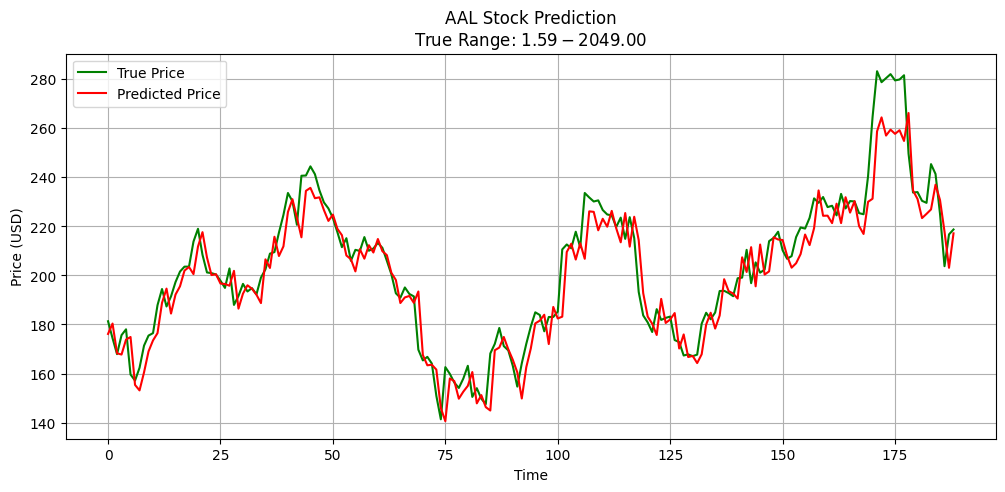


Normalized Metrics:
Test Loss: 0.0239
RMSE: 0.0957
MAE: 0.0712
R²: 0.8931

Denormalized Metrics (USD):
RMSE: $9.57
MAE: $7.12
MAPE: 3.45%


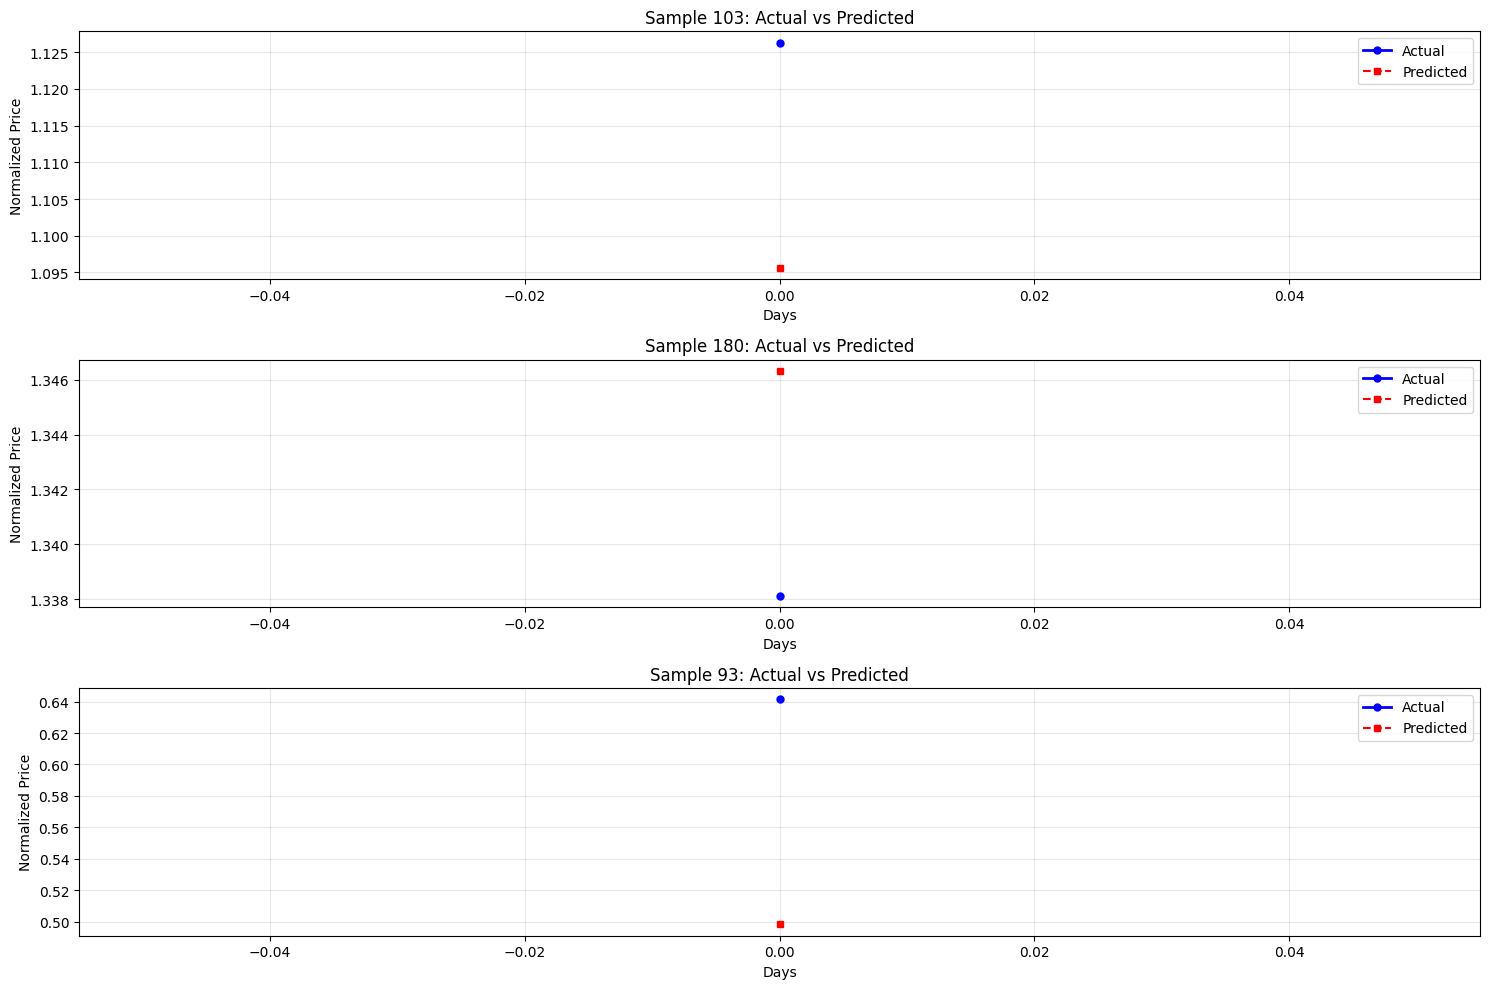

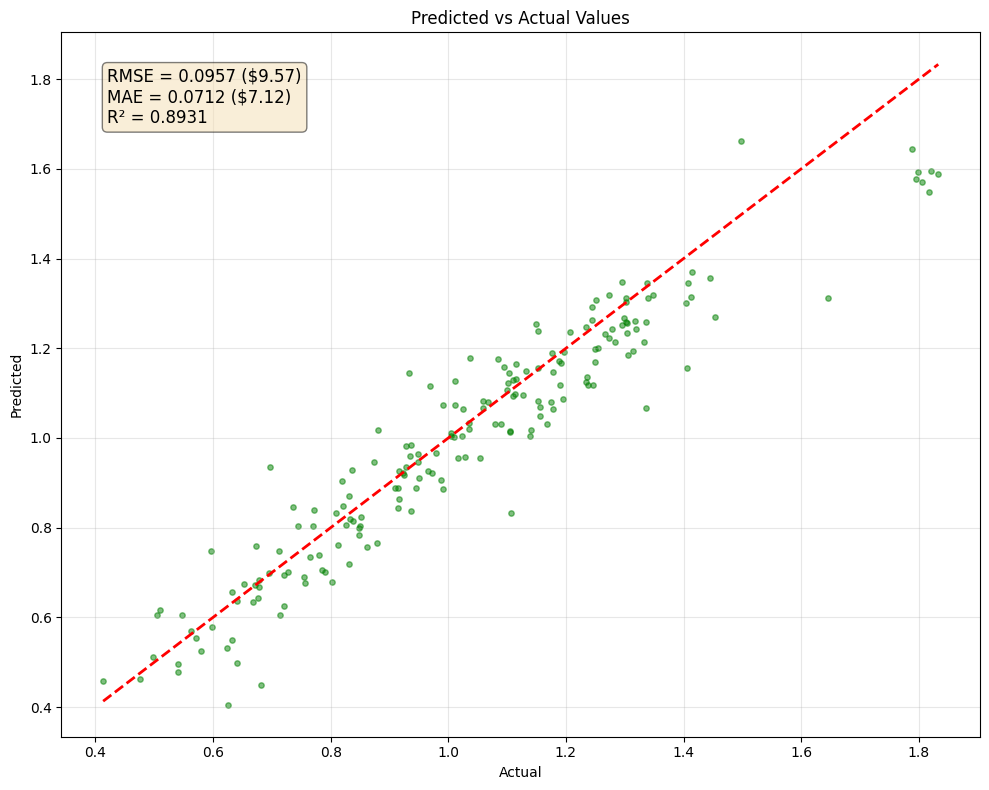

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


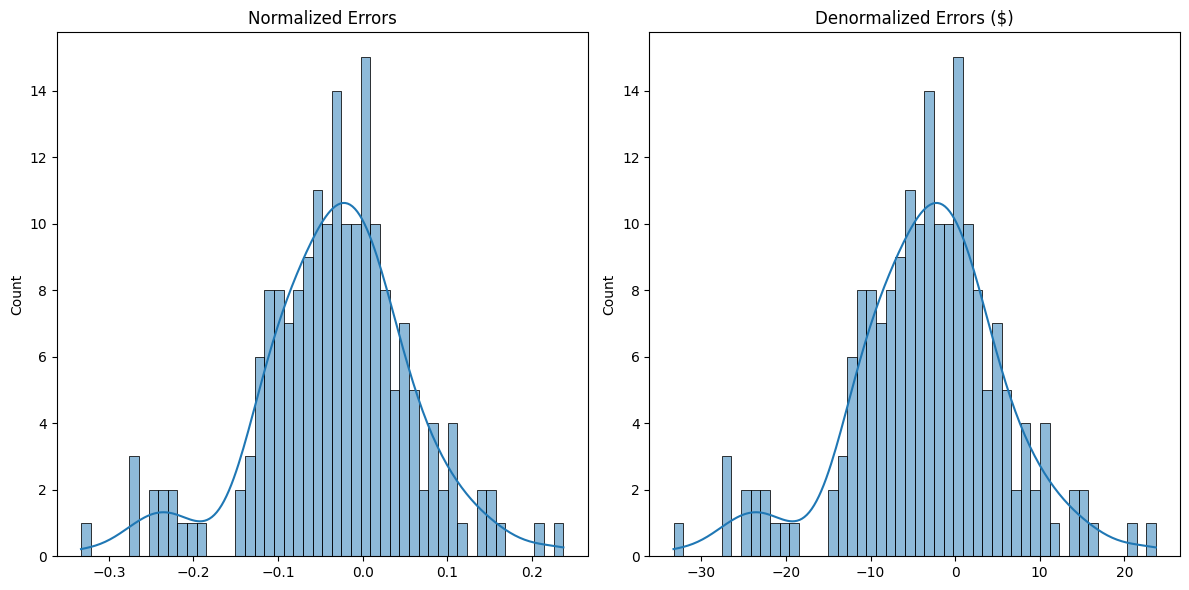

In [22]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tqdm import tqdm
import torch

# Assuming you have your scaler object saved during training
# If not, you'll need to recreate it with the original data range
# Example for MinMaxScaler (adjust if you used StandardScaler):
# scaler = MinMaxScaler()
# scaler.min_, scaler.scale_ = your_saved_min, your_saved_scale

# Define the loss function
criterion = StockLoss(delta=0.5, direction_weight=0.6, margin=0.02)

# Set model to evaluation mode
model.eval()

# Initialize lists to store predictions and ground truth
all_predictions = []
all_ground_truth = []

# Initialize total test loss
total_test_loss = 0

# Disable gradient calculation
with torch.no_grad():
    for i, (x_batch, y_batch) in enumerate(tqdm(test_loader, desc="Testing")):
        # Move data to device
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        
        
        predictions = model(x_batch)
        
        # Calculate loss
        loss = criterion(predictions, y_batch)
        total_test_loss += loss.item() * x_batch.size(0)
        
        # Store predictions and ground truth
        all_predictions.append(predictions.cpu().numpy())
        all_ground_truth.append(y_batch.cpu().numpy())

# Calculate average test loss
avg_test_loss = total_test_loss / len(test_loader.dataset)

# Concatenate all batches
all_predictions = np.concatenate(all_predictions, axis=0)
all_ground_truth = np.concatenate(all_ground_truth, axis=0)

# Flatten for metrics calculation
y_true = all_ground_truth.flatten()
y_pred = all_predictions.flatten()

# Calculate metrics with error handling
try:
    # Normalized metrics
    # Calculate metrics with proper parenthesis balancing
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), 1e-8))) * 100

    # Denormalization example (replace with your actual scaler values)
    data_min = 100.0  # Minimum price in dataset
    data_max = 200.0  # Maximum price in dataset

    y_true_denorm = y_true * (data_max - data_min) + data_min
    y_pred_denorm = y_pred * (data_max - data_min) + data_min

    # Denormalized metrics
    rmse_denorm = np.sqrt(mean_squared_error(y_true_denorm, y_pred_denorm))
    mae_denorm = mean_absolute_error(y_true_denorm, y_pred_denorm)
    mape_denorm = np.mean(np.abs((y_true_denorm - y_pred_denorm) / np.maximum(np.abs(y_true_denorm), 1e-8))) * 100
     # Plotting with USD values
    plt.figure(figsize=(12, 5))
    plt.plot(y_true_denorm, label="True Price", color='green')
    plt.plot(y_pred_denorm, label="Predicted Price", color='red')
    plt.title(f"AAL Stock Prediction\nTrue Range: ${df['close'].min():.2f}-${df['close'].max():.2f}")
    plt.xlabel("Time")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    print(f"\nNormalized Metrics:")
    print(f"Test Loss: {avg_test_loss:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")
    
    print(f"\nDenormalized Metrics (USD):")
    print(f"RMSE: ${rmse_denorm:.2f}")
    print(f"MAE: ${mae_denorm:.2f}")
    print(f"MAPE: {mape_denorm:.2f}%")

except Exception as e:
    print(f"Error calculating metrics: {str(e)}")

# Visualization
try:
    # Plot 1: Time-series comparison
    plt.figure(figsize=(15, 10))
    for i in range(3):
        idx = np.random.randint(0, len(all_predictions))
        plt.subplot(3, 1, i+1)
        plt.plot(all_ground_truth[idx], 'b-o', label='Actual', linewidth=2, markersize=5)
        plt.plot(all_predictions[idx], 'r--s', label='Predicted', linewidth=1.5, markersize=5)
        plt.title(f"Sample {idx+1}: Actual vs Predicted")
        plt.xlabel("Days")
        plt.ylabel("Normalized Price")
        plt.grid(alpha=0.3)
        plt.legend()
    plt.tight_layout()
    plt.savefig('time_series_comparison.png', dpi=300)
    plt.show()

    # Plot 2: Scatter plot
    plt.figure(figsize=(10, 8))
    plt.scatter(y_true, y_pred, alpha=0.5, c='green', s=15)
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--', linewidth=2)
    plt.title("Predicted vs Actual Values")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.grid(alpha=0.3)
    
    textstr = '\n'.join((
        f'RMSE = {rmse:.4f} (${rmse_denorm:.2f})',
        f'MAE = {mae:.4f} (${mae_denorm:.2f})',
        f'R² = {r2:.4f}',
       ))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    plt.gca().text(0.05, 0.95, textstr, transform=plt.gca().transAxes,
                  fontsize=12, verticalalignment='top', bbox=props)
    
    plt.tight_layout() 
    plt.savefig('scatter_plot.png', dpi=300)
    plt.show() 

    # Plot 3: Error distribution
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    errors_norm = y_pred - y_true
    sns.histplot(errors_norm, kde=True, bins=50)
    plt.title('Normalized Errors')
    
    plt.subplot(1, 2, 2)
    errors_denorm = y_pred_denorm - y_true_denorm
    sns.histplot(errors_denorm, kde=True, bins=50)
    plt.title('Denormalized Errors ($)')
    
    plt.tight_layout()
    plt.savefig('error_distribution.png', dpi=300)
    plt.show()

except Exception as e:
    print(f"Error generating plots: {str(e)}")